In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [2]:
DATA_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

### 1. Prep Dataset
---

In [3]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "Dataset.csv")).iloc[:,:88].set_index("Code ID")
treatment_df = pd.read_csv(os.path.join(DATA_DIR, "Treatments.csv")).set_index("Code ID")

# Errors in input
# 2006097 - Cardiopulmonary symptom onset = 0026-01-01
# 2009206 - Cardiopulmonary symptom onset = 0001-01-01

samples_to_remove = [2006097, 2009206]

data_df = data_df.drop(samples_to_remove)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

In [4]:
# Add encoding variables
data_df['Amyloid type'] = data_df['Amyloid type'].apply(lambda x: utils.map_encoding(x, amyloid.enc_amyloid_type))
data_df['Sex'] = data_df['Sex'].apply(lambda x: utils.map_encoding(x, amyloid.enc_sex))
data_df['Ethnicity'] = data_df['Ethnicity'].apply(lambda x: utils.map_encoding(x, amyloid.enc_ethnicity))
data_df['Race'] = data_df['Race'].apply(lambda x: utils.map_encoding(x, amyloid.enc_race))
data_df['Education'] = data_df['Education'].apply(lambda x: utils.map_encoding(x, amyloid.enc_education))
data_df['Abdominal fat pad CR staining'] = data_df['Abdominal fat pad CR staining'].apply(lambda x: utils.map_encoding(x, amyloid.enc_staining))
data_df['Bone marrow CR staining'] = data_df['Bone marrow CR staining'].apply(lambda x: utils.map_encoding(x, amyloid.enc_staining))

for var in amyloid.amyloid_ros:
    data_df[var] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_ros))

data_df['Primary organ'] = data_df['Primary organ'].apply(lambda x: utils.map_encoding(x, amyloid.enc_organ))
data_df['Secondary organ'] = data_df['Secondary organ'].apply(lambda x: utils.map_encoding(x, amyloid.enc_organ))

for var in amyloid.amyloid_symptoms:
    data_df[var] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_descriptors))

data_df["SIFE M-component"] = data_df["SIFE M-component"].apply(lambda x: utils.map_encoding(x, amyloid.enc_m_components))
data_df["UIFE M-component"] = data_df["UIFE M-component"].apply(lambda x: utils.map_encoding(x, amyloid.enc_m_components))

data_df["Mayo  2004 cardiac biomarker staging"] = data_df["Mayo  2004 cardiac biomarker staging"].apply(lambda x: utils.map_encoding(x, amyloid.enc_mayo_2004))
data_df["BU (BNP-based) cardiac staging"] = data_df["BU (BNP-based) cardiac staging"].apply(lambda x: utils.map_encoding(x, amyloid.enc_bu_2019))

# Censor
# Select either last visit or time of death, include time to event in months
data_df['status'] = np.where(data_df['Date of death'].notna(), 1, 0)
data_df['time'] = data_df[['Date of death','Date of last visit']].max(axis=1) - data_df['Date of diagnosis']
data_df['time'] = data_df['time'] / pd.Timedelta(days=30)
data_df = data_df.rename(columns={'Age at diagnosis (y)':'Age'})

### 2. Prep Treatments
---

In [5]:
# Treatment dictionary
treatment_dict = {int(line.split(None, 1)[0]): line.split(None, 1)[1].strip() for line in amyloid.enc_treaments.strip().split('\n')}

# Treatment groups dictionary
# Split the string into lines
lines = amyloid.enc_treatment_groups.strip().split('\n')

# Create a dictionary from the lines
treatment_groups_dict = {}
for line in lines:
    treatment, numbers = line.split("\t")
    #print(treatment, "- ", numbers)
    numbers_list = [int(num) for num in numbers.split(',')]
    for num in numbers_list:
        treatment_groups_dict[num] = treatment.strip()

treatment_groups_dict[99] = 'Other'
treatment_df['treatment_eskd'] = treatment_df['Treatment code'].isin([51,52,54])

# Fix dates (2):
fix_dates = {"0020-09-23":"09/23/20", "0023-05-05":"05/05/23"}

for idx,row in treatment_df.iterrows():
    if row['Start date'] in fix_dates.keys():
        treatment_df.loc[idx,'Start date'] = fix_dates[row['Start date']]

# Fix Treatment Dates
treatment_df['treatment_name'] = treatment_df['Treatment code'].apply(lambda x: treatment_dict[x])
treatment_df['treatment_group'] = treatment_df['Treatment code'].apply(lambda x: treatment_groups_dict[x])
treatment_df['Date of diagnosis'] = pd.to_datetime(treatment_df['Date of diagnosis'], format="mixed")
treatment_df['Start date'] = pd.to_datetime(treatment_df['Start date'], format="mixed")
treatment_df['End date'] = pd.to_datetime(treatment_df['End date'], format="mixed")
treatment_df['Day 0 date'] = pd.to_datetime(treatment_df['Day 0 date'], format="mixed")

In [7]:
data_df.rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t')
treatment_df.to_csv(os.path.join(PROCESSED_DIR, "treatments_processed.tsv"), sep='\t')

### 3. Explore
---

In [6]:
# select only AL amyloid
AL_df = data_df[data_df['Amyloid type'] == "AL"]

# Select for ones we know the LC isotype
AL_df = AL_df[AL_df['Kappa or lambda PCD'].notna()]


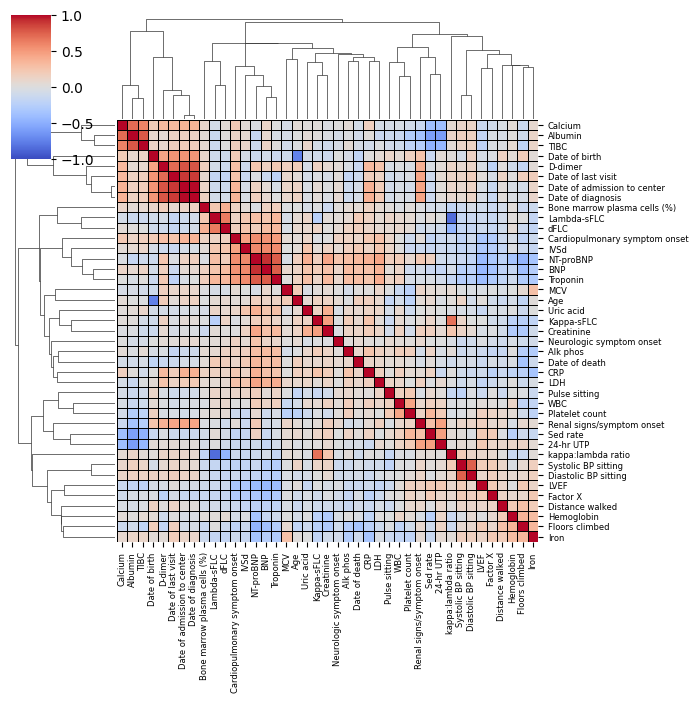

In [7]:
clustermap = sns.clustermap(
    AL_df[amyloid.qvars + amyloid.dates + ['Age']].corr('spearman'),
    xticklabels=True,
    yticklabels=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linecolor='k',
    linewidths=0.5,
    figsize=(8,8),
    #col_label_kws={'fontsize': 12}
)

_ = clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), fontsize=6)
_ = clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), fontsize=6)

plt.savefig("figures/spearman_corr_clustermap.pdf", dpi=200, bbox_inches="tight")

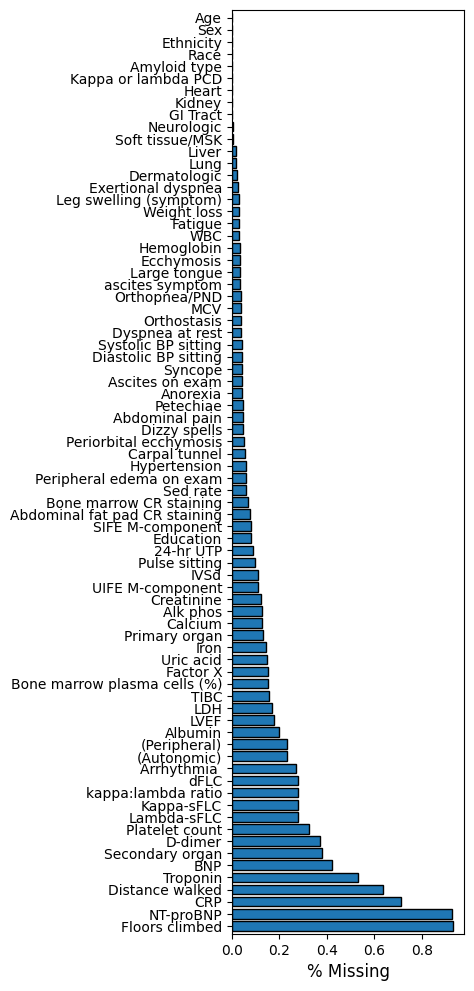

In [8]:
plot.missing_barplot(AL_df[amyloid.qvars + amyloid.catvars], figsize=(3,12))
plt.savefig("figures/missing_variables.pdf", dpi=200, bbox_inches="tight")

In [9]:
# Only keep variables with < 60% missingness
AL_filt_df = AL_df.loc[:,AL_df.isna().sum() / AL_df.shape[0] < 0.6]
print("Variables removed: ", set(AL_df) - set(AL_filt_df))

Variables removed:  {'Neurologic symptom onset', 'CRP', 'Distance walked', 'Floors climbed', 'NT-proBNP', 'Mayo  2004 cardiac biomarker staging'}


In [10]:
# Only include categorical and continuous variables and dependent variables
vars_for_imputation = np.intersect1d(amyloid.qvars + amyloid.catvars + ['time','status'], list(AL_filt_df))
AL_filt_df[vars_for_imputation].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_for_imputation_01.tsv"), sep='\t')

# Continuous variables and dependent variables
_vars = np.intersect1d(amyloid.qvars, list(AL_filt_df))
AL_filt_df[_vars].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t')